## Linear models for predicting MLB salary in 6 years with rookie stats

### Future notes / todos
* Distribution of log(salary) is somewhat normal. Need to confirm if this is OK or not.
* Should put age into feature set and see if the younger the rookie then better chance of a higher salary.
* Need some type of pairplot as probably some of my features are correlated like HRs and TBs.
* Probably need to get more data

In [29]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import baseball as bb

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [32]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

Merge the stats and salary data frames together. `df_stats` has only rookie batters from 1985-2017. `df_salary` has all MLB salaries from 1985-2017 as long as the player was paid for 6 years from rookie season.

In [33]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'name_year',
        'Salary', 'SrvTm', 'today_salary']]
# salary_stats_df = salary_stats_df[salary_stats_df.AB >=200]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary) # log transform the salary

# remove any obs with 0 hits
salary_stats_df = salary_stats_df[salary_stats_df.H != 0]
salary_stats_df.shape

(918, 23)

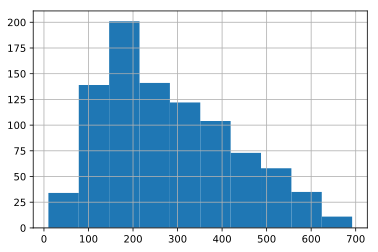

In [34]:
salary_stats_df.AB.hist();

Create `X` and `y`, and make a train / test split of 20%.

In [35]:
y = salary_stats_df.log_today_salary

X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'age']]

print('X sample:',X.shape)
print('y sample:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print('X train:', X_train.shape)
print('y train:', y_train.shape)

X sample: (918, 14)
y sample: (918,)
X train: (734, 14)
y train: (734,)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


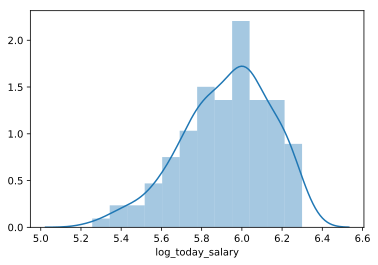

In [36]:
sns.distplot(y_train[y_train <= 6.3]);

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


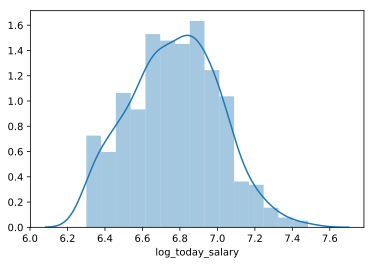

In [37]:
sns.distplot(y_train[y_train > 6.3]);

Combine `X` and `y` training data sets and calculate the correlation matrix.

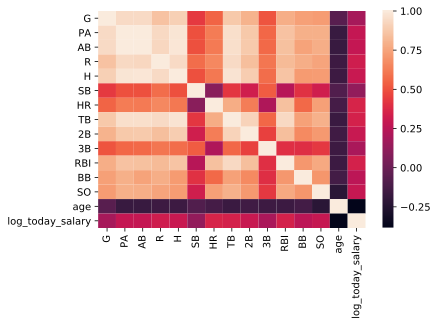

In [38]:
Xy = pd.concat([X_train, y_train], axis=1)
# sns.pairplot(Xy);

corr = Xy.corr()
sns.heatmap(corr);

Review the features and determine if any feature needs a transformation

In [39]:
import math
def create_hist(X_train):
    fig, ax_rows = plt.subplots(math.ceil(X_train.shape[1] / 2), 2, figsize=(10, 10*X_train.shape[1] // 2))
    # plt.figure(figsize=(12,6))
    # plt.subplots(X_train.shape[1] // 2, 2)

    for f in range(X_train.shape[1]):
        ax_row_left, ax_row_right = ax_rows[f//2]

        if f%2 == 0:
            ax = ax_row_left
        else:
            ax = ax_row_right
        ax.hist(X_train.iloc[:,f], )
        ax.set_xlabel(X_train.columns[f])
    fig.savefig('misc/hist_plots.png')

Normalize feautres

In [40]:
X_train['HR_log'] = np.log1p(X_train.HR)
X_train['RBI_log'] = np.log1p(X_train.RBI)
X_train['H_boxcox'] = stats.boxcox(X_train.H)[0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [41]:
X_train.columns

Index(['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB',
       'SO', 'age', 'HR_log', 'RBI_log', 'H_boxcox'],
      dtype='object')

Run the models and add in a new transformed feature each time.

In [42]:
# original features
features = ['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB',
       'SO', 'age']

results = bb.run_models(X_train.loc[:,features],y_train, 'no transform')

# HR transform
features = ['G', 'PA', 'AB', 'R', 'H', 'SB', 'TB', '2B', '3B', 'RBI', 'BB',
       'SO', 'age', 'HR_log']

results = bb.run_models(X_train.loc[:,features],y_train, 'HR transform', results)

# HR + RBI transform

features = ['G', 'PA', 'AB', 'R', 'H', 'SB', 'TB', '2B', '3B', 'BB',
       'SO', 'age', 'HR_log', 'RBI_log']

results = bb.run_models(X_train.loc[:,features],y_train, 'HR/RBI transform', results)

# HR + RBI + H transform

features = ['G', 'PA', 'AB', 'R', 'SB', 'TB', '2B', '3B', 'BB',
       'SO', 'age', 'HR_log', 'RBI_log', 'H_boxcox']

results = bb.run_models(X_train.loc[:,features],y_train, 'HR/RBI/H transform', results)


# features = ['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB',
#        'SO', 'age', 'HR_log', 'RBI_log', 'H_boxcox']

results

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,no transform,HR transform,HR/RBI transform,HR/RBI/H transform
lasso cv - 0.006812920690579615,0.162076,0.161048,0.161128,0.161128
lasso poly 2 cv - 0.006812920690579615,0.161400,0.161047,0.161110,0.161107
lasso poly 3 cv - 0.006812920690579615,NaN,0.163069,0.162731,0.162730
lasso poly 3 cv - 0.01291549665014884,0.163394,NaN,NaN,NaN
lasso poly 4 cv - 0.01291549665014884,0.164274,0.164009,0.163784,0.163773
lasso poly 5 cv - 0.01291549665014884,NaN,NaN,0.164410,0.164426
lasso poly 5 cv - 0.024484367468222266,0.164601,0.164861,NaN,NaN
linear model - cv10,0.162838,0.162551,0.162788,0.162940


In [43]:
summary = pd.concat([results.idxmin(),results.min()], axis=1)
summary.columns = ['model','min_mse']
summary.sort_values('min_mse')

,model,min_mse
HR transform,lasso poly 2 cv - 0.006812920690579615,0.161047
HR/RBI/H transform,lasso poly 2 cv - 0.006812920690579615,0.161107
HR/RBI transform,lasso poly 2 cv - 0.006812920690579615,0.161110
no transform,lasso poly 2 cv - 0.006812920690579615,0.161400


In [44]:
lasso = make_pipeline(PolynomialFeatures(4), StandardScaler(), Lasso(alpha=0.01291549665014884))
features = ['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB',
       'SO', 'age']

lasso.fit(X_train.loc[:,features],y_train)
lasso.score(X_train.loc[:,features],y_train)

0.2680393762801345